# Import packages

In [1]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import random
from ipyleaflet import Map, LocalTileLayer, Polyline, LegendControl, ScaleControl
from ipywidgets import Layout
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import time
import datetime
from scipy import signal
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import copy

from anomaly_maps import ChallMagMap
import ppigrf
import magnav

In [2]:
# Larger view width

from IPython.display import display, HTML
display(HTML('<style>.container{width:75% !important; }</style>'))

# 0 - Dataset general informations

This dataset has 4 different flights :
- 1002
- 1003
- 1004
- 1005

Each flight contains lines that are intended to segment the flight into different parts. We have a lot of differents measurements including magneometers. Truth data here is __"IGRFMAG1"__, the magnetometer compensated by SGL (Geological Survey company).

## 0.1 - Time, number of data and sampling frequency

In [3]:
# Extract sampling frequency, duration and number of data collected from the dataset

for n in range(2,6):
    
    df    = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt100{n}')
    lines = df.LINE.unique()

    total_duration  = 0
    total_data      = 0
    total_freq_samp = 0

    for l in lines :

        df_lines = pd.DataFrame()
        mask     = (df.LINE == l)
        df_lines = pd.concat([df_lines,df.loc[mask]],axis=0)

        freq_samp = magnav.sampling_frequency(df_lines)
        nb_data   = np.shape(df_lines)[0]
        duration = nb_data*(1/freq_samp)

        total_duration  += duration
        total_data      += np.shape(df_lines)[0]
        total_freq_samp += freq_samp/len(lines)
        total_lines      = len(lines)

    
    print(f'Flight : 100{n} | Total flight time : {magnav.to_hms(total_duration)} | Number of data collected : {total_data} | Sampling frequency : {total_freq_samp:.2f}Hz | Number of unique flight lines : {total_lines}')
    
del df,lines,df_lines,mask

Flight : 1002 | Total flight time : 05h:45m:55s | Number of data collected : 207578 | Sampling frequency : 10.00Hz | Number of unique flight lines : 28
Flight : 1003 | Total flight time : 04h:26m:42s | Number of data collected : 160030 | Sampling frequency : 10.00Hz | Number of unique flight lines : 10
Flight : 1004 | Total flight time : 02h:15m:38s | Number of data collected : 81408 | Sampling frequency : 10.00Hz | Number of unique flight lines : 21
Flight : 1005 | Total flight time : 02h:16m:12s | Number of data collected : 81731 | Sampling frequency : 10.00Hz | Number of unique flight lines : 10


## 0.2 - Descriptive statistics

In [4]:
df1002 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1002')
df1003 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1003')
df1004 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1004')
df1005 = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt1005')

In [5]:
df1002.describe()

,MSL_Z,NORM_ACC,BARO,CUR_ACHi,CUR_ACLo,CUR_ACPWR,CUR_BAT1,CUR_BAT2,CUR_COM1,CUR_FLAP,...,V_BLOCK,V_CABT,V_FAN,V_GYRO1,V_GYRO2,V_OUTPWR,V_RESn,V_RESp,V_SERVO,YAWRT
count,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,...,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000
mean,981.063505,0.006073,921.846454,2.677637,2.721092,26.038372,0.054179,0.039179,2.527515,2.464722,...,28.139541,26.138118,48.272935,50.467686,27.203686,26.442239,-47.604327,48.183299,47.584976,0.038591
std,1061.238388,0.085699,1018.402078,0.281251,0.188009,1.672891,0.002976,0.005068,0.011294,0.020124,...,0.024228,0.303667,0.012083,0.021330,0.027443,0.167470,0.014188,0.014556,0.054332,1.356609
min,111.930000,-0.771000,106.020000,2.435000,2.459000,21.156000,0.046000,0.030000,2.299000,0.972000,...,28.056000,25.473000,48.239000,50.398000,27.106000,26.023000,-47.637000,48.119000,47.444000,-7.000000
25%,322.520000,-0.031000,287.040000,2.454000,2.486000,24.761000,0.052000,0.035000,2.524000,2.462000,...,28.129000,25.892000,48.263000,50.454000,27.185000,26.318000,-47.617000,48.170000,47.551000,-0.660000
50%,380.960000,0.005000,345.320000,2.468000,2.848000,26.124000,0.054000,0.039000,2.529000,2.466000,...,28.147000,26.118000,48.272000,50.465000,27.204000,26.438000,-47.610000,48.177000,47.590000,0.000000
75%,1218.750000,0.046000,1149.597500,3.026000,2.875000,27.372000,0.057000,0.044000,2.533000,2.467000,...,28.157000,26.372000,48.282000,50.487000,27.223000,26.560000,-47.590000,48.199000,47.627000,0.730000
max,3306.680000,0.734000,3154.740000,3.571000,3.021000,30.181000,0.062000,0.050000,2.555000,3.565000,...,28.196000,27.001000,48.316000,50.518000,27.304000,26.919000,-47.491000,48.216000,47.708000,6.980000


In [6]:
df1003.describe()

,MSL_Z,NORM_ACC,BARO,CUR_ACHi,CUR_ACLo,CUR_ACPWR,CUR_BAT1,CUR_BAT2,CUR_COM1,CUR_FLAP,...,V_BLOCK,V_CABT,V_FAN,V_GYRO1,V_GYRO2,V_OUTPWR,V_RESn,V_RESp,V_SERVO,YAWRT
count,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,...,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000,160030.000000
mean,587.392906,0.004306,581.883387,3.036786,2.491351,27.737872,0.055373,0.044817,2.519065,2.464022,...,28.145966,25.897834,48.261191,50.440459,27.183396,26.226746,-47.575450,48.170536,47.485782,0.029691
std,194.814668,0.078484,188.946075,0.118923,0.063808,1.576505,0.002819,0.004268,0.016321,0.022896,...,0.025820,0.298245,0.011046,0.018584,0.020064,0.153574,0.013343,0.014046,0.045860,1.276448
min,126.420000,-0.551000,128.850000,2.393000,2.392000,23.307000,0.048000,0.036000,2.324000,1.007000,...,28.060000,25.237000,48.233000,50.373000,27.103000,25.844000,-47.612000,48.112000,47.403000,-6.760000
25%,430.300000,-0.038000,429.520000,3.045000,2.474000,26.594000,0.053000,0.041000,2.516000,2.462000,...,28.131000,25.648000,48.252000,50.426000,27.169000,26.100000,-47.586000,48.159000,47.451000,-0.640000
50%,439.590000,0.004000,438.940000,3.060000,2.481000,27.925000,0.055000,0.044000,2.520000,2.464000,...,28.155000,25.863000,48.259000,50.435000,27.184000,26.209000,-47.581000,48.164000,47.478000,0.000000
75%,827.940000,0.047000,815.830000,3.073000,2.488000,29.028000,0.058000,0.049000,2.524000,2.467000,...,28.164000,26.119000,48.269000,50.455000,27.197000,26.341000,-47.561000,48.186000,47.511000,0.670000
max,953.040000,0.696000,929.600000,4.945000,3.469000,32.149000,0.295000,0.055000,2.583000,3.598000,...,28.201000,26.767000,48.308000,50.517000,27.273000,26.732000,-47.455000,48.206000,47.671000,8.110000


In [7]:
df1004.describe()

,MSL_Z,NORM_ACC,BARO,CUR_ACHi,CUR_ACLo,CUR_ACPWR,CUR_BAT1,CUR_BAT2,CUR_COM1,CUR_FLAP,...,V_BLOCK,V_CABT,V_FAN,V_GYRO1,V_GYRO2,V_OUTPWR,V_RESn,V_RESp,V_SERVO,YAWRT
count,81408.000000,81408.000000,81408.000000,81408.000000,81408.000000,81408.000000,81408.000000,81408.000000,81408.000000,81408.000000,...,81408.000000,81408.000000,81408.000000,81408.000000,81408.000000,81408.00000,81408.000000,81408.000000,81408.000000,81408.000000
mean,819.268759,0.001194,774.683419,3.026466,2.481301,28.930154,0.055748,0.043857,2.517834,2.466533,...,28.142273,25.781644,48.252499,50.414196,27.162466,26.22362,-47.574951,48.165303,47.420318,0.009653
std,82.140254,0.045533,80.834370,0.025106,0.007179,1.198910,0.002236,0.003200,0.012765,0.018317,...,0.025328,0.223454,0.009300,0.016688,0.019522,0.10962,0.010778,0.011443,0.037368,0.707084
min,263.190000,-0.462000,230.760000,2.490000,2.462000,24.235000,0.036000,0.020000,2.334000,1.400000,...,28.064000,25.225000,48.229000,50.381000,27.066000,25.74600,-47.605000,48.119000,47.363000,-6.020000
25%,830.890000,-0.022000,786.690000,3.008000,2.476000,28.229000,0.054000,0.041000,2.514000,2.461000,...,28.127000,25.603000,48.246000,50.403000,27.150000,26.13800,-47.582000,48.158000,47.392000,-0.340000
50%,833.920000,0.001000,789.760000,3.026000,2.479000,29.192000,0.056000,0.043000,2.518000,2.468000,...,28.152000,25.722000,48.251000,50.408000,27.163000,26.19700,-47.578000,48.161000,47.411000,0.010000
75%,837.780000,0.024000,792.980000,3.045000,2.488000,29.849000,0.057000,0.046000,2.524000,2.471000,...,28.159000,25.912000,48.258000,50.425000,27.175000,26.28500,-47.573000,48.167000,47.438000,0.370000
max,1004.040000,0.456000,954.010000,3.605000,2.501000,35.001000,0.119000,0.055000,2.577000,3.389000,...,28.202000,26.691000,48.297000,50.483000,27.244000,26.70800,-47.461000,48.205000,47.582000,4.640000


In [8]:
df1005.describe()

,MSL_Z,NORM_ACC,BARO,CUR_ACHi,CUR_ACLo,CUR_ACPWR,CUR_BAT1,CUR_BAT2,CUR_COM1,CUR_FLAP,...,V_BLOCK,V_CABT,V_FAN,V_GYRO1,V_GYRO2,V_OUTPWR,V_RESn,V_RESp,V_SERVO,YAWRT
count,81731.000000,81731.000000,81731.000000,81731.00000,81731.000000,81731.000000,81731.000000,81731.000000,81731.00000,81731.000000,...,81731.000000,81731.000000,81731.000000,81731.000000,81731.000000,81731.000000,81731.000000,81731.000000,81731.000000,81731.000000
mean,1199.510149,0.000245,1147.954134,3.02971,2.481064,26.500609,0.054624,0.045493,2.51908,2.467402,...,28.145265,26.188804,48.273456,50.459325,27.205075,26.429511,-47.577799,48.177052,47.551044,0.030828
std,767.160222,0.032525,731.053538,0.02588,0.006689,1.491083,0.002983,0.004907,0.02011,0.017912,...,0.025830,0.286284,0.011862,0.019105,0.019866,0.146680,0.014330,0.014709,0.043336,0.588137
min,175.170000,-0.365000,177.970000,2.91700,2.457000,23.059000,0.048000,0.036000,2.30700,1.118000,...,28.058000,25.544000,48.241000,50.416000,27.135000,26.067000,-47.613000,48.143000,47.458000,-4.690000
25%,832.200000,-0.012000,796.480000,3.01900,2.476000,25.308000,0.052000,0.041000,2.51900,2.463000,...,28.126000,25.955000,48.263000,50.441000,27.191000,26.309000,-47.591000,48.163000,47.516000,-0.170000
50%,835.980000,-0.001000,801.430000,3.03500,2.479000,26.502000,0.055000,0.045000,2.52300,2.466000,...,28.153000,26.190000,48.273000,50.460000,27.206000,26.431000,-47.577000,48.178000,47.548000,0.000000
75%,1252.370000,0.012000,1196.770000,3.04700,2.488000,27.718000,0.057000,0.050000,2.52600,2.475000,...,28.165000,26.422000,48.282000,50.473000,27.219000,26.549000,-47.564000,48.192000,47.579000,0.190000
max,3817.450000,0.627000,3648.280000,3.21700,2.495000,30.087000,0.062000,0.055000,2.54000,3.029000,...,28.206000,26.821000,48.312000,50.514000,27.278000,26.777000,-47.457000,48.210000,47.675000,4.810000


# 1 - Select a flight

Select here the flight to visualize in the next cells

## 1.1 - Flight number

In [9]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5)],
    value=3,
    description='Load flight')
display(w_flight)

ToggleButtons(description='Load flight', index=1, options=(('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5))…

In [10]:
df_sel_flight = eval('df100'+str(w_flight.value))

## 1.2 - Flight section

In [11]:
# Create a widget to select the line(s) of the selected flight

w_lines = widgets.SelectMultiple(
    options     = df_sel_flight.LINE.unique(),
    description = 'Select line(s):',
    disabled    = False)
display(w_lines)

SelectMultiple(description='Select line(s):', options=(1003.01, 1003.02, 1003.03, 1003.04, 1003.05, 1003.06, 1…

In [12]:
# Extracting selcted line(s) from the dataset

df_sel_lines = pd.DataFrame()
for line in w_lines.value:
    mask     = (df_sel_flight.LINE == line)
    df_sel_lines = pd.concat([df_sel_lines,df_sel_flight.loc[mask]],axis=0)

duration = np.shape(df_sel_lines)[0]*(1/freq_samp)

print(f'Rows : {np.shape(df_sel_lines)[0]} | Columns : {np.shape(df_sel_lines)[1]} | Duration : {magnav.to_hms(duration)}\n')

Rows : 129633 | Columns : 92 | Duration : 03h:36m:02s



# 2 - View of a specific trajectory

There is different flight which each contains different lines. To better understand the different trajectories, we will plot them with the possiblity to select specifics lines.

## 2.1 - OpenStreetMap

In [13]:
# Show map, does not work on jupyter lab

m = Map(center   = [45.1278, -75.5120],
        zoom     = 8,
        max_zoom = 12,
        min_zoom = 8,
        layout   = Layout(width='100%',height='800px'))

m.add_layer(LocalTileLayer(path="../data/external/tiles/{z}/{x}/{y}.png"))

legend = LegendControl({},name="Legend",position="topright")
step = 10 
for line in w_lines.value:
    color = magnav.get_random_color()
    mask = (df_sel_flight.LINE == line)
    locations = (df_sel_flight
                 .loc[mask,['LAT','LONG']][::step]
                 .values
                 .tolist())
    pline = Polyline(
        locations = locations,
        color     = color,
        fill      = False,
        opacity   = 1)
    m.add_layer(pline)
    legend.add_legend_element(str(line),color)

m.add_control(legend)
m.add_control(ScaleControl(position='bottomleft'))

m

Map(center=[45.1278, -75.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

## 2.3 - Magnetic anomaly maps

In [14]:
# Load anomaly maps

EasternMap = ChallMagMap('../data/raw/Eastern_2.h5')
RenfrewMap = ChallMagMap('../data/raw/Renfrew_2.h5')
GscMap     = ChallMagMap('../data/external/Canada_MAG_RES_200m.hdf5')
WDMAM      = ChallMagMap('../data/external/map_WDMAM.hdf5')

### 2.3.1 - Canada map

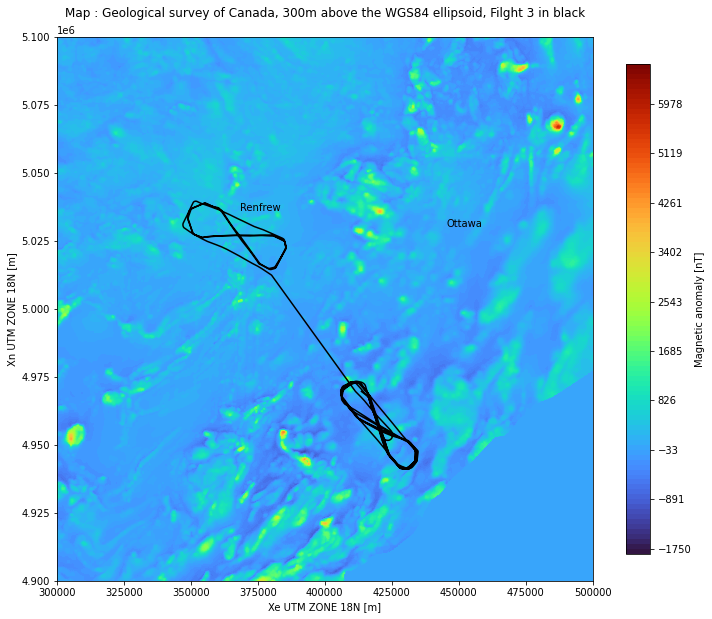

In [15]:
fig, ax = plt.subplots(figsize=[12,10])

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax)
ax = GscMap.plot(ax, plot_city=True)
ax.set_title(f'Map : Geological survey of Canada, {GscMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);
ax.set_xlim(3e5, 5e5)
ax.set_ylim(4.90e6, 5.1e6)

plt.show()

### 2.3.2 - Challenge maps

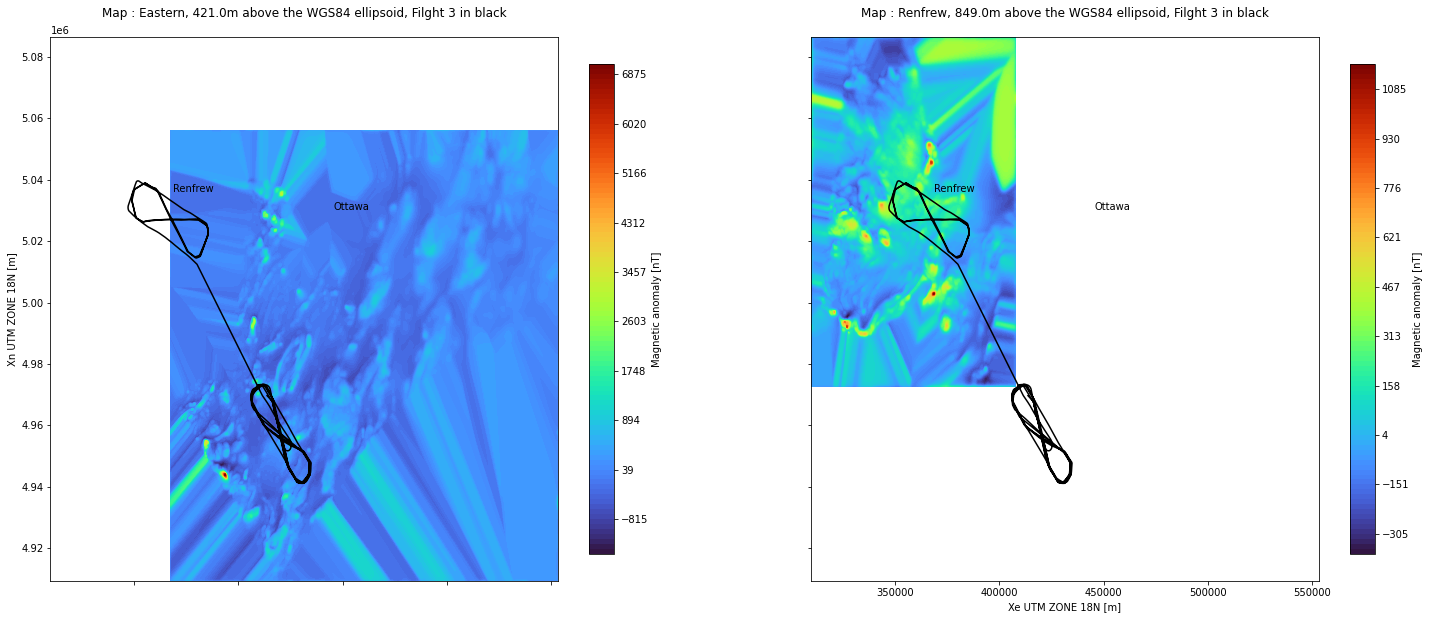

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=[25,10])

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax1)
ax1 = EasternMap.plot(ax1,plot_city=True)
ax1.set_title(f'Map : Eastern, {EasternMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax2)
ax2 = RenfrewMap.plot(ax2, plot_city=True)
ax2.set_title(f'Map : Renfrew, {RenfrewMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

plt.show()

### 2.3.3 - World Digital Magnetic Anomaly Map

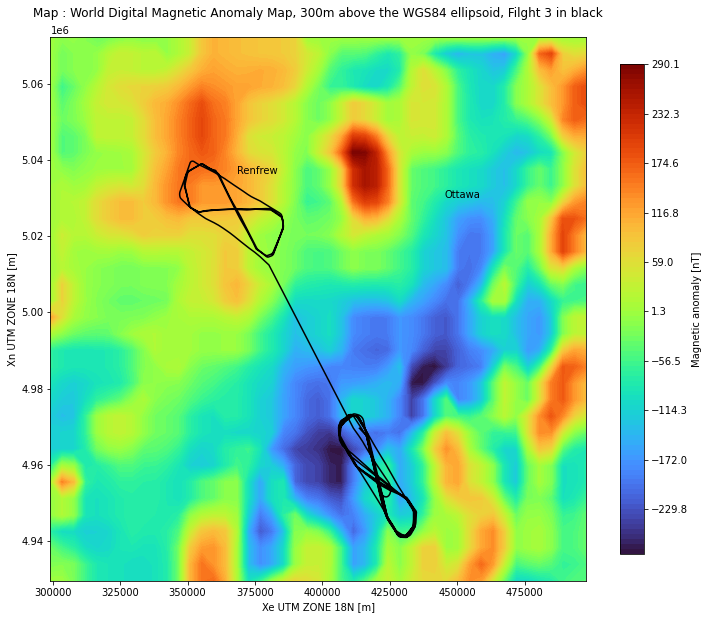

In [17]:
fig, ax = plt.subplots(figsize=[12,10])

df_sel_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax)
ax = WDMAM.plot(ax, plot_city=True)
ax.set_title(f'Map : World Digital Magnetic Anomaly Map, {WDMAM.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

plt.show()

### 2.3.4 - Map resolutions

The goal is to compare the accuracy between anomaly maps and truth data and see the impact of map accuracy for navigation.<br>
We have 4 different maps available :<br>
- Anomaly map of Canada (mid resolution)
- Anomaly map of Renfrew (high resolution)
- Anomaly map of Eastern Renfrew, south of Ottawa (high resolution)
- World Digital Magnetic Anomaly Map (low resolution)

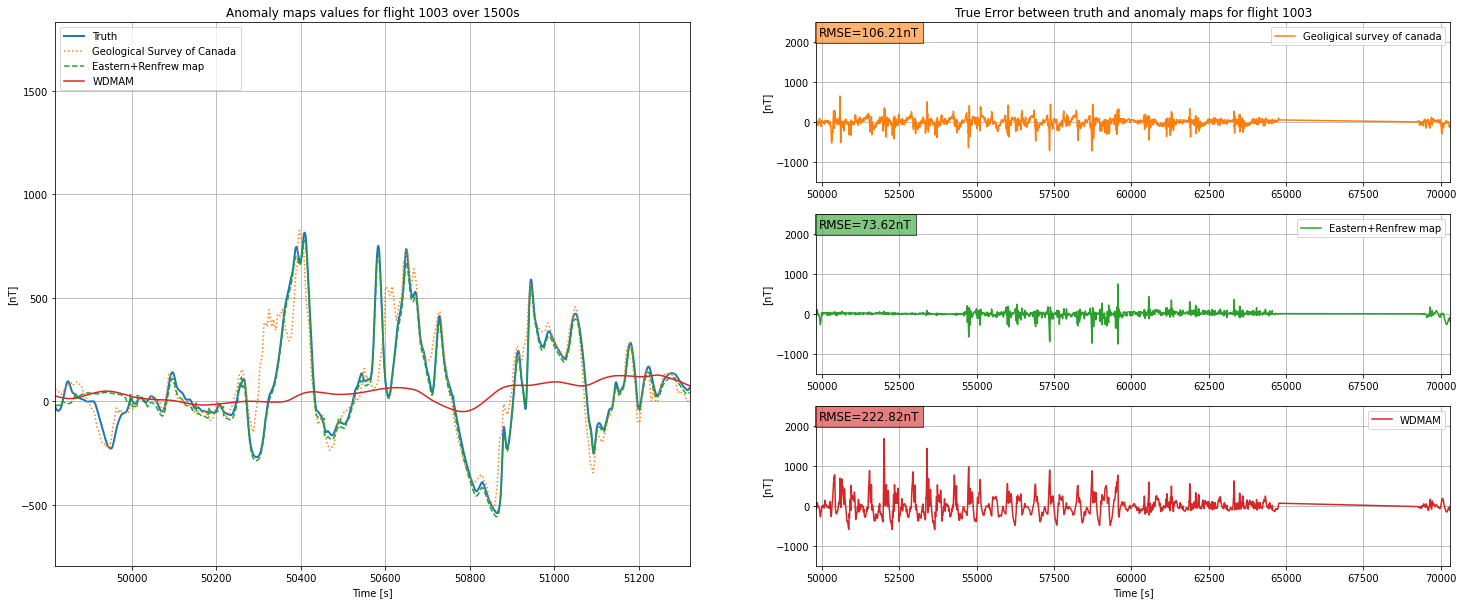

In [18]:
df_maps = pd.DataFrame()

# Interpolation of anomaly maps
df_maps['IGRFMAG1']    = copy.deepcopy(df_sel_flight['IGRFMAG1'])
df_maps['GSC_map']     = GscMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['Eastern_map'] = EasternMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['Renfrew_map'] = RenfrewMap.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)
df_maps['WDMAM_map']   = WDMAM.interpolate(df_sel_flight.UTM_X, df_sel_flight.UTM_Y)

# Remove linear trend
df_maps['IGRFMAG1']    = signal.detrend(df_maps['IGRFMAG1'])
df_maps['WDMAM_map']   = signal.detrend(df_maps['WDMAM_map'])
df_maps['Eastern_map'] = signal.detrend(df_maps['Eastern_map'])
df_maps['Renfrew_map'] = signal.detrend(df_maps['Renfrew_map'])
df_maps['GSC_map']     = signal.detrend(df_maps['GSC_map'])

# Calculate error between truth data and anomaly maps
GSC_map_error     = (df_maps['IGRFMAG1']-df_maps['GSC_map'])
Eastern_map_error = (df_maps['IGRFMAG1']-df_maps['Eastern_map'])
Renfrew_map_error = (df_maps['IGRFMAG1']-df_maps['Renfrew_map'])
WDMAM_map_error   = (df_maps['IGRFMAG1']-df_maps['WDMAM_map'])

# Calculate RMSE between truth data and anomaly maps
GSC_map_rmse      = magnav.rmse(df_maps['GSC_map'],df_maps['IGRFMAG1'])
WDMAM_map_rmse    = magnav.rmse(df_maps['WDMAM_map'],df_maps['IGRFMAG1'])

# Fusion of Eastern and Renfrew maps
East_Ren_map = df_maps['Eastern_map'].where(np.abs(Eastern_map_error)<np.abs(Renfrew_map_error))
df_maps['East_Ren_map'] = East_Ren_map.fillna(df_maps['Renfrew_map'])

East_Ren_map_error = (df_maps['IGRFMAG1']-df_maps['East_Ren_map'])
East_Ren_map_rmse = magnav.rmse(df_maps['East_Ren_map'],df_maps['IGRFMAG1'])

# Plot results
plt.figure(figsize=[25,10])
ax1 = plt.subplot(3,2,2)
ax2 = plt.subplot(3,2,4)
ax3 = plt.subplot(3,2,6)
ax4 = plt.subplot(1,2,1)

ax4.plot(df_maps['IGRFMAG1'],'C0',linewidth=2)
ax4.plot(df_maps['GSC_map'],'C1:')
ax4.plot(df_maps['East_Ren_map'],'C2--')
ax4.plot(df_maps['WDMAM_map'],'C3')

ax4.legend(['Truth','Geological Survey of Canada','Eastern+Renfrew map','WDMAM'],loc='upper left')
ax4.set_title(f'Anomaly maps values for flight 100{w_flight.value} over 1500s')
ax4.set_ylabel('[nT]'), ax4.set_xlabel('Time [s]')
ax4.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[0]+1500)
ax4.grid()

ax1.plot(GSC_map_error,'C1'),ax2.plot(East_Ren_map_error,'C2'), ax3.plot(WDMAM_map_error,'C3')

# RMSE box
ax1.text(df_maps.index[0]+80,2150,f'RMSE={GSC_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C1',alpha=0.6))
ax2.text(df_maps.index[0]+80,2150,f'RMSE={East_Ren_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))
ax3.text(df_maps.index[0]+80,2150,f'RMSE={WDMAM_map_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C3',alpha=0.6))


ax1.set_title(f'True Error between truth and anomaly maps for flight 100{w_flight.value}')
ax1.set_ylabel('[nT]'), ax2.set_ylabel('[nT]'), ax3.set_ylabel('[nT]'), ax3.set_xlabel('Time [s]')
ax1.axes.set_ylim(bottom=-1500, top=2500), ax2.axes.set_ylim(bottom=-1500, top=2500), ax3.axes.set_ylim(bottom=-1500, top=2500)
ax1.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1]), ax2.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1]), ax3.axes.set_xlim(left=df_maps.index[0], right=df_maps.index[-1])
ax1.legend(['Geoligical survey of canada']), ax2.legend(['Eastern+Renfrew map']), ax3.legend(['WDMAM'])
ax1.grid(), ax2.grid(), ax3.grid()

plt.show()

As we can see higher resolution are closer from truth data than lower resolution maps. If we want to use maps as truth data to train a ML model we will need a high resolution map.

# 3 - Flight events

We have access to evenements that happened during the flight. These evenements can be useful to better understand the impact of aircraft on magnetic field. 

## 3.1 - Events during the selected section(s)

In [19]:
line_df = pd.read_csv(f'../data/interim/readmes/Flight_100{w_flight.value}/Flt100{w_flight.value}-lines.csv')
coms_df = pd.read_csv(f'../data/interim/readmes/Flight_100{w_flight.value}/Flt100{w_flight.value}-comments.csv')

sel_lines_df = pd.DataFrame()
sel_coms_df  = pd.DataFrame()

for n in range(len(w_lines.value)):
    df_concat = line_df.loc[line_df['Line Number'] == w_lines.value[n]]
    sel_lines_df = pd.concat([sel_lines_df,df_concat])

print(sel_lines_df.to_string(index=False),'\n')

for n in range(len(w_lines.value)):
    df_concat = coms_df.loc[coms_df['Line Number'] == w_lines.value[n]]
    sel_coms_df = pd.concat([sel_coms_df,df_concat])

print(sel_coms_df.to_string(index=False))

del line_df, coms_df

 Start Time  End Time  Line Number           Description
    50713.0   54497.0      1003.02 Eastern Free Fly 400m
    54639.0   59475.0      1003.04 Eastern Free Fly 800m
    60243.0   64586.0      1003.08 Renfrew Free Fly 400m 

    Time                         Parameter Message  Line Number
50771.63                               IN BOX AREA      1003.02
50806.38                                POWER LINE      1003.02
50943.57                                POWER LINE      1003.02
51478.22   RADIO 4 MIN AGO. CALL ON COMM 1 & COM 2      1003.02
51599.18                                POWER LINE      1003.02
51680.22                                POWER LINE      1003.02
51751.22                              TRAAIN TRACK      1003.02
52313.19                           LIGHTS BLINKING      1003.02
52473.55                      LIGHTS BLINKING DONE      1003.02
52502.45                             FUEL PUMPS ON      1003.02
52710.15                              FLAPS 10 SET      1003.02
52

## 3.2 - Label creation for different events

In [20]:
# TODO : creation de label pour le training (Ex : si evenement avion alors 1 sir evenement sol alors 2 etc)

# 4 - Visualization of magnetic sensors position and direction

There is 2 types of magnetic sensors :
- 5 Scalar magnetometers ~ optically-pumped ,cesium split-beam named Mag 1/2/3/4/5
- 3 Vector fluxgate magnetometers ~ named Flux B/C/D

In [21]:
def plot_mag(time):
    # Scalar magnetometers position
    Scal_mag = np.array([[-12.01,0,1.37],
                        [-0.60,-0.36,0],
                        [-1.28,-0.36,0],
                        [-3.53,0,0],
                        [-3.79,0,1.20]])

    # Vector magnetometers position
    Vect_mag = np.array([[-8.92,0,0.96],
                         [-4.06,0.42,0],
                         [-4.06,-0.42,0]])

    fig = plt.figure(figsize=[15,15])
    ax  = fig.add_subplot(projection='3d')

    # Plot scalar magnetometers position
    for n in range(5):
        ax.scatter(Scal_mag[n][0],Scal_mag[n][1],Scal_mag[n][2],color='red',marker='^')
        ax.text(Scal_mag[n][0],Scal_mag[n][1],Scal_mag[n][2],str(n+1))

    # Plot vector magnetometers position
    for n in range(3):
        name = ['B','C','D']
        ax.scatter(Vect_mag[n][0],Vect_mag[n][1],Vect_mag[n][2],color='blue',marker='*')
        ax.text(Vect_mag[n][0],Vect_mag[n][1],Vect_mag[n][2],name[n])

    # Origin
    ax.scatter(0,0,0,color='green',marker='x'), ax.text(0,0,0,'')

    # Origin arrows
    ax.quiver(0,0,0,1,0,0), ax.quiver(0,0,0,0,1,0), ax.quiver(0,0,0,0,0,1) # x,y,z arrow

    # Mag vectors direction
    scale_factor = 0.00004
    ax.quiver(-8.92,0,0.96,
              -scale_factor*df_sel_flight.loc[time,'FLUXB_X'],
              -scale_factor*df_sel_flight.loc[time,'FLUXB_Y'],
              -scale_factor*df_sel_flight.loc[time,'FLUXB_Z'],color='green')
    ax.quiver(-4.06,0.42,0,
              scale_factor*df_sel_flight.loc[time,'FLUXC_X'],
              scale_factor*df_sel_flight.loc[time,'FLUXC_Y'],
              scale_factor*df_sel_flight.loc[time,'FLUXC_Z'],color='green')
    ax.quiver(-4.06,-0.42,0,
              scale_factor*df_sel_flight.loc[time,'FLUXD_X'],
              scale_factor*df_sel_flight.loc[time,'FLUXD_Y'],
              scale_factor*df_sel_flight.loc[time,'FLUXD_Z'],color='green')


    # Legend and labels
    ax.legend(['Mag 1 - Tail stinger', 'Mag 2 - Front cabin aft of cockpit', 'Mag 3 - Mid cabin aft of cockpit', 'Mag 4 - Rear cabin floor','Mag 5 - Rear cabin ceiling',
               'Flux B - Tail at base of stinger','Flux C - Rear cabin port side','Flux D - Rear cabin aft side',
               'Center - Front seat rail'])
    ax.set_xlabel('X [m]'), ax.set_ylabel('Y [m]'), ax.set_zlabel('Z [m]')

    # Axes limit
    ax.axes.set_xlim3d(left=-12.5, right=12.5), ax.axes.set_ylim3d(bottom=-12.5, top=12.5), ax.axes.set_zlim3d(bottom=-12.5, top=12.5)

    plt.show()

    # Plot image
    fig, ax = plt.subplots(figsize=[12,12])
    img = image.imread('../data/external/Images/plane.png')
    ax.imshow(img)

    # Remove axes
    ax.spines['bottom'].set_visible(False), ax.spines['top'].set_visible(False), ax.spines['left'].set_visible(False), ax.spines['right'].set_visible(False)
    ax.set_xticks([]) ,ax.set_yticks([])

    plt.show()

In [22]:
widgets.interact(plot_mag, time=(df_sel_flight.index[0],df_sel_flight.index[-1],0.1))

interactive(children=(FloatSlider(value=60065.5, description='time', max=70311.0, min=49820.0), Output()), _do…

<function __main__.plot_mag(time)>

# Add gradient

In [23]:
df_sel_flight['FLUXB_X_grad'] = np.gradient(df_sel_flight['FLUXB_X'])
df_sel_flight['FLUXB_Y_grad'] = np.gradient(df_sel_flight['FLUXB_Y'])
df_sel_flight['FLUXB_Z_grad'] = np.gradient(df_sel_flight['FLUXB_Z'])

df_sel_flight['FLUXC_X_grad'] = np.gradient(df_sel_flight['FLUXC_X'])
df_sel_flight['FLUXC_Y_grad'] = np.gradient(df_sel_flight['FLUXC_Y'])
df_sel_flight['FLUXC_Z_grad'] = np.gradient(df_sel_flight['FLUXC_Z'])

df_sel_flight['FLUXD_X_grad'] = np.gradient(df_sel_flight['FLUXD_X'])
df_sel_flight['FLUXD_Y_grad'] = np.gradient(df_sel_flight['FLUXD_Y'])
df_sel_flight['FLUXD_Z_grad'] = np.gradient(df_sel_flight['FLUXD_Z'])

df_sel_flight['PITCH_grad'] = np.gradient(df_sel_flight['PITCH'])
df_sel_flight['ROLL_grad'] = np.gradient(df_sel_flight['ROLL'])
df_sel_flight['AZIMUTH_grad'] = np.gradient(df_sel_flight['AZIMUTH'])

# 5 - Data correction

Multiples corrections are applied to the initial data.

## 5.1 - Tolles Lawson

### 5.1.1 - Patterns

In [24]:
flight_number = 2
df_pattern    = pd.read_hdf('../data/interim/Flt_data.h5',key=f'Flt100{flight_number}')

mask_1 = (df_pattern.LINE == 1002.02)
mask_2 = (df_pattern.LINE == 1002.20)

tl_sq = df_pattern[mask_1] # Square Tolles-Lawson pattern
tl_cl = df_pattern[mask_2] # Cloverleaf Tolles-Lawson pattern

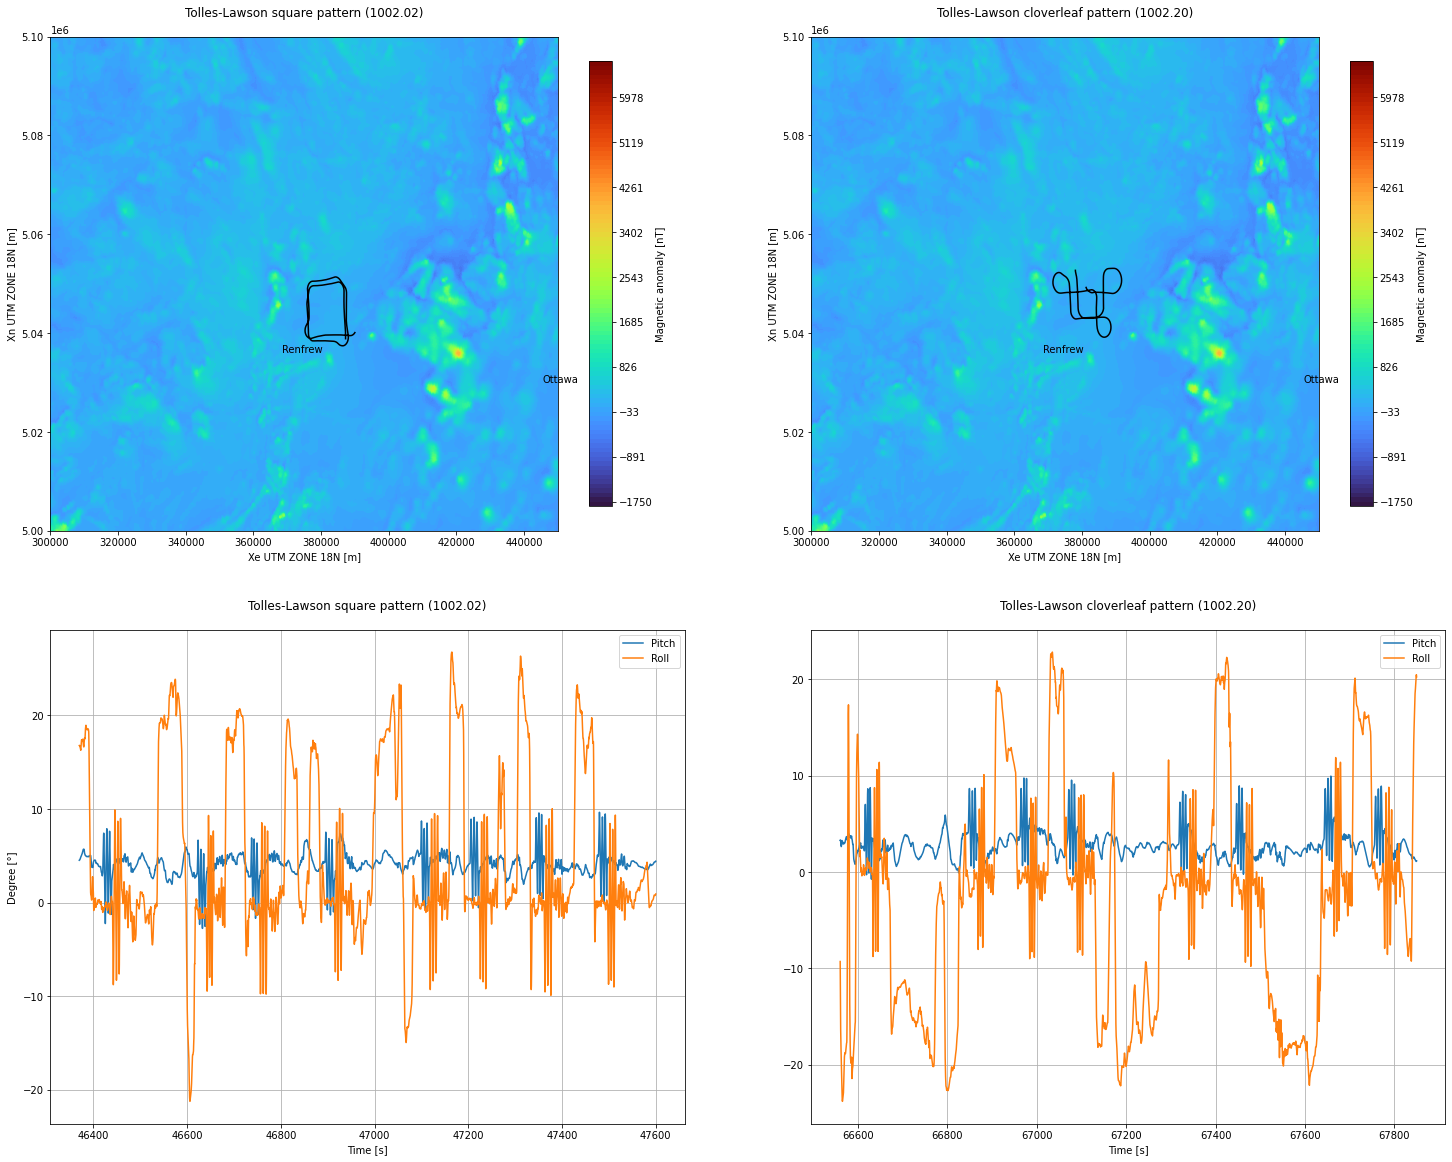

In [25]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,sharex=False,sharey=False,figsize=[25,20])

tl_sq.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax1)
ax1 = GscMap.plot(ax1,plot_city=True)
ax1.set_title('Tolles-Lawson square pattern (1002.02)',pad=20);
ax1.set_xlim(3e5, 4.5e5)
ax1.set_ylim(5e6, 5.1e6);

tl_cl.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax2)
ax2 = GscMap.plot(ax2, plot_city=True)
ax2.set_title('Tolles-Lawson cloverleaf pattern (1002.20)',pad=20);
ax2.set_xlim(3e5, 4.5e5)
ax2.set_ylim(5e6, 5.1e6);

ax3.plot(tl_sq[['PITCH','ROLL']])
ax3.set_title('Tolles-Lawson square pattern (1002.02)',pad=20)
ax3.legend(['Pitch','Roll'])
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Degree [°]')
ax3.grid()

ax4.plot(tl_cl[['PITCH','ROLL']])
ax4.set_title('Tolles-Lawson cloverleaf pattern (1002.20)',pad=20)
ax4.legend(['Pitch','Roll'])
ax4.set_xlabel('Time [s]')
ax4.grid()

plt.show()

### 5.1.2 - Band pass filter

low cut = 0.1 Hz, High cut = 0.9 Hz, sampling frequency = 10 Hz

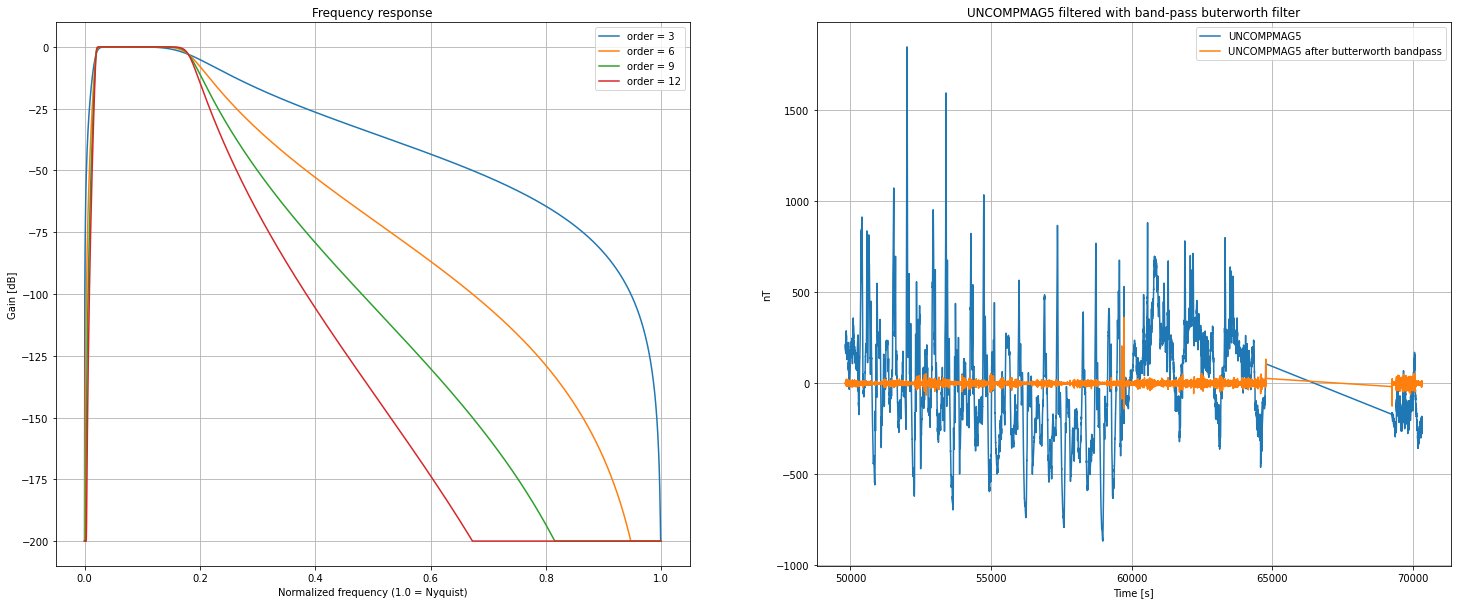

In [26]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9

fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

for order in [3,6,9,12]:
    sos  = magnav.create_butter_filter(lowcut,highcut,fs,order=order)
    w, h = signal.sosfreqz(sos,worN=2000)
    db = 20*np.log10(np.maximum(np.abs(h),1e-10))
    ax1.plot(w/np.pi,db,label=f'order = {order}')
    
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')
ax1.legend()
ax1.grid()

sig = signal.detrend(np.array(df_sel_flight['UNCOMPMAG5']))
ax2.plot(df_sel_flight.index,sig,label='UNCOMPMAG5')

y = magnav.apply_butter_filter(sig,lowcut,highcut,fs,order=4)
ax2.plot(df_sel_flight.index,y,label='UNCOMPMAG5 after butterworth bandpass')

ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('nT')
ax2.legend()
ax2.set_title('UNCOMPMAG5 filtered with band-pass buterworth filter')

plt.show()

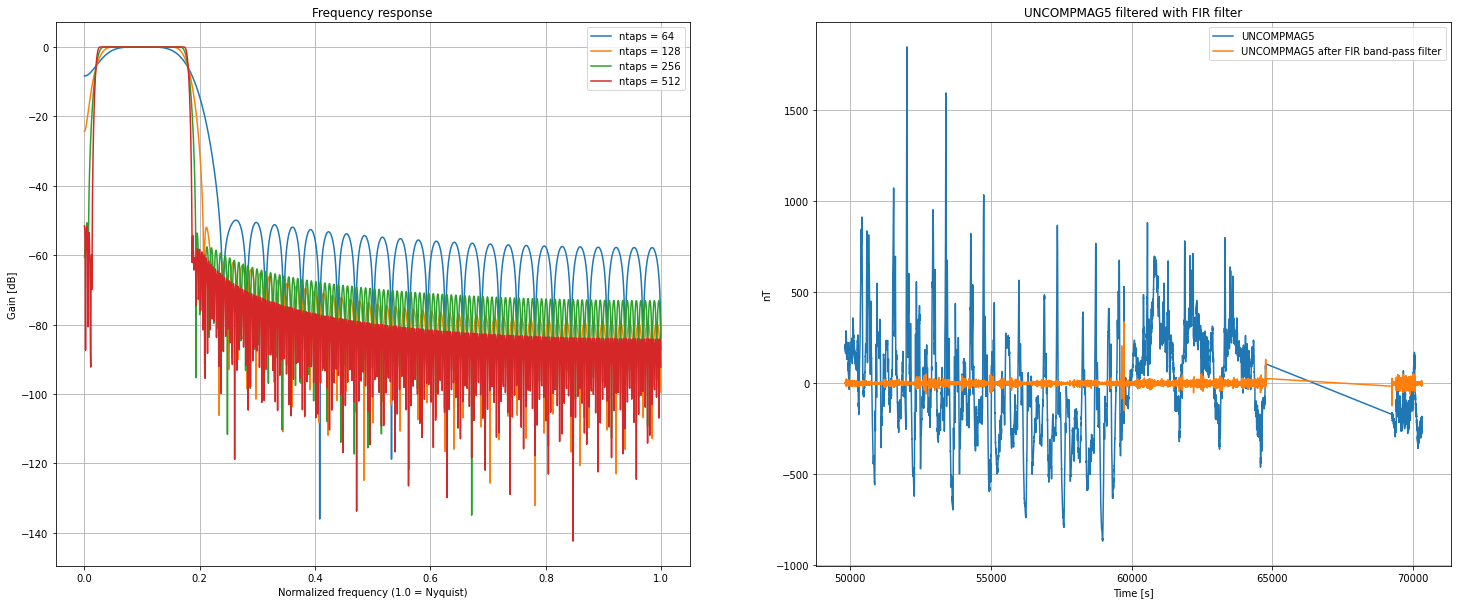

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

for ntaps in [64,128,256,512]:
    taps_hamming = magnav.create_firwin_filter(lowcut,highcut,fs,ntaps)
    w, h = signal.freqz(taps_hamming,1,worN=2000)
    db = 20*np.log10(np.maximum(np.abs(h),1e-10))
    ax1.plot(w/np.pi,db,label=f'ntaps = {ntaps}')
    
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')
ax1.grid()
ax1.legend()

sig = signal.detrend(np.array(df_sel_flight['UNCOMPMAG5']))
ax2.plot(df_sel_flight.index,sig,label='UNCOMPMAG5')

y = magnav.apply_firwin_filter(sig,lowcut,highcut,fs,ntaps=255,window='hamming')
ax2.plot(df_sel_flight.index,y,label='UNCOMPMAG5 after FIR band-pass filter')
ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('nT')
ax2.legend()
ax2.set_title('UNCOMPMAG5 filtered with FIR filter')

plt.show()

### 5.1.3 - Tolles Lawson coefficients | Square pattern

In [28]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG1'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG2'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG3'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG4'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG5'],
                                  lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_sq'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_sq'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_sq'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_sq'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_sq'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

### 5.1.4 - Tolles Lawson coefficients | Cloverleaf pattern

In [29]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG1'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG2'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG3'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG4'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG5'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_cl'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_cl'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_cl'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_cl'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_cl'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

### 5.1.5 - Tolles Lawson coefficients | Square+Cloverleaf pattern

In [30]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Combine SQ and CL patterns
tl_sqcl = df_pattern[mask_1+mask_2]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG1'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG2'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG3'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG4'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG5'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

### 5.1.6 - Effect of various patterns

Mag 2 is not shown due to bad results (uncomment the lines below to show mag 2)

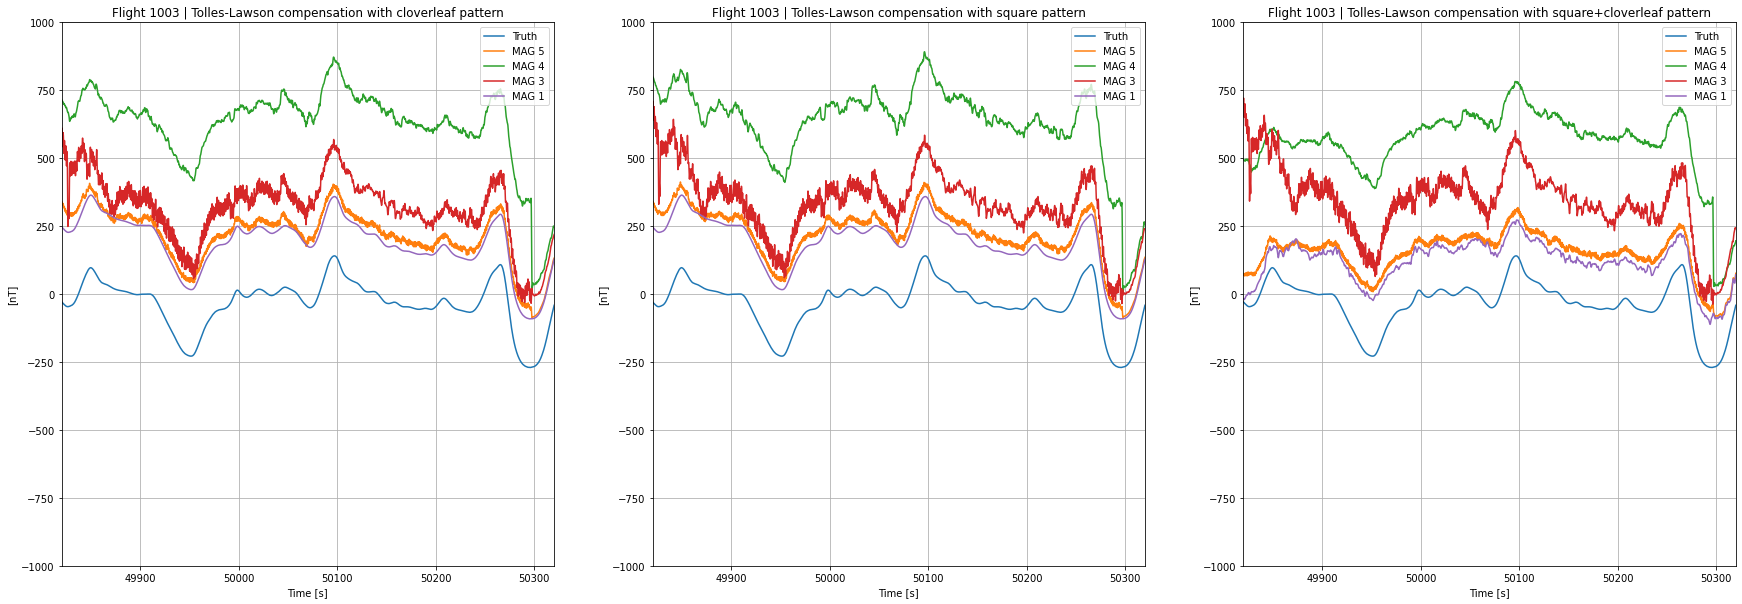

In [31]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,10])

# Cloverleaf pattern
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['IGRFMAG1']),label='Truth')
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag5_cl']),label='MAG 5')
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag4_cl']),label='MAG 4')
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag3_cl']),label='MAG 3')
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag1_cl']),label='MAG 1')
# ax1.plot(df_sel_flight['TL_comp_mag2_cl']-np.mean(df_sel_flight['TL_comp_mag2_cl']),label='MAG 2')

ax1.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax1.axes.set_ylim(-1000,1000)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with cloverleaf pattern')
ax1.legend(loc='upper right')
ax1.grid()

# Square pattern
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['IGRFMAG1']),label='Truth')
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag5_sq']),label='MAG 5')
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag4_sq']),label='MAG 4')
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag3_sq']),label='MAG 3')
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag1_sq']),label='MAG 1')
#ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag2_sq']),label='MAG 2')

ax2.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax2.axes.set_ylim(-1000,1000)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square pattern')
ax2.legend(loc='upper right')
ax2.grid()

# Square+Cloverleaf pattern
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['IGRFMAG1']),label='Truth')
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag5_sqcl']),label='MAG 5')
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag4_sqcl']),label='MAG 4')
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag3_sqcl']),label='MAG 3')
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag1_sqcl']),label='MAG 1')
# ax3.plot(df_sel_flight['TL_comp_mag2_sqcl']-np.mean(df_sel_flight['TL_comp_mag2_sqcl']),label='MAG 2')

ax3.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax3.axes.set_ylim(-1000,1000)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square+cloverleaf pattern')
ax3.legend(loc='upper right')
ax3.grid()

<font size="4">Explication :</font>

Mag 1 is currently not corresponding to Truth. This is because we still have other compensation to do.

## 5.2 - Lag correction

In [32]:
# definition lag

Lag = sensor_offset / aircraft_speed

In [33]:
Lag = 11.18/np.mean(df_sel_flight['TRUE_AS'])
print(f'Lag = {Lag:.2f}s')

Lag = 0.17s


We approximate lag to 0.2 because we only have an accuracy of 0.1, we need 0.01 accuracy to apply a better lag correction.

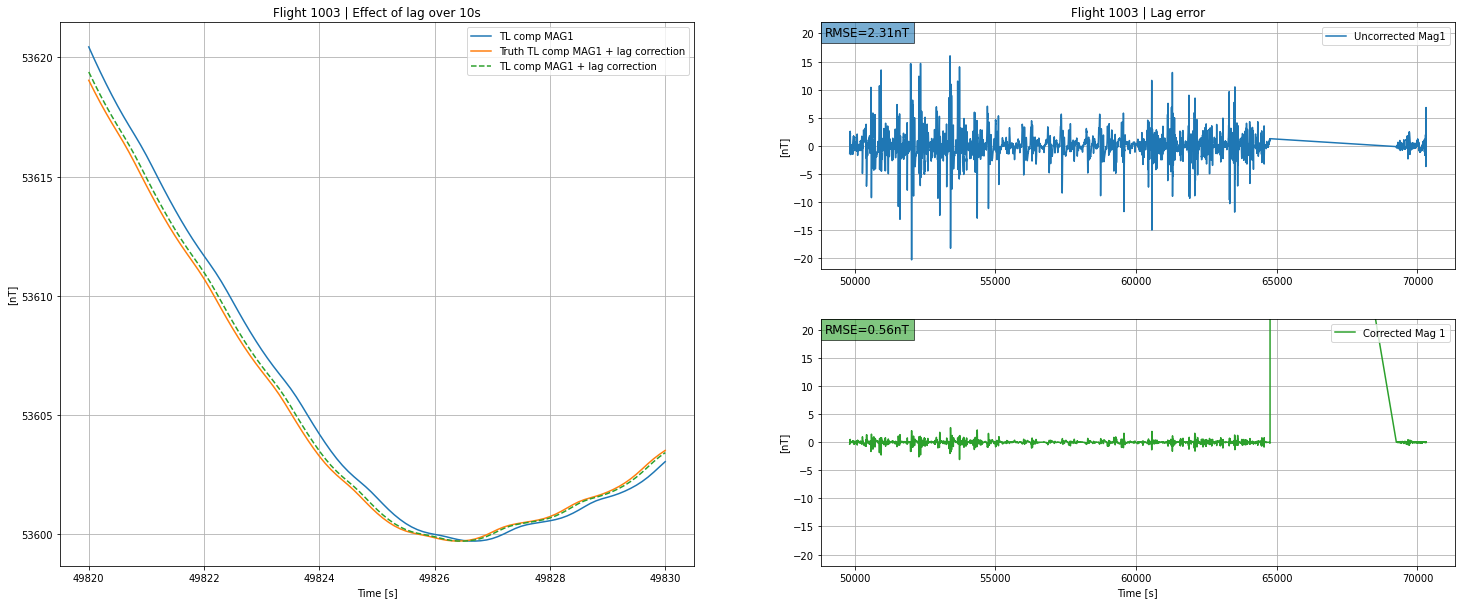

In [34]:
our_lag_cor       = df_sel_flight['COMPMAG1'].drop([df_sel_flight.index[0],df_sel_flight.index[1]])
our_lag_cor.index = df_sel_flight.index[:-2]
UNLAG_df = df_sel_flight.drop([df_sel_flight.index[-1],df_sel_flight.index[-2]])

plt.figure(figsize=[25,10])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,4)

ax1.plot(UNLAG_df[['COMPMAG1','LAGMAG1']][:df_sel_flight.index[0]+10])
ax1.plot(our_lag_cor[:df_sel_flight.index[0]+10],'--')
ax1.legend(['TL comp MAG1','Truth TL comp MAG1 + lag correction','TL comp MAG1 + lag correction'])
ax1.set_title(f'Flight 100{w_flight.value} | Effect of lag over 10s')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.grid()

ax2.plot(UNLAG_df['LAGMAG1']-UNLAG_df['COMPMAG1'],'C0')
ax2.legend(['Uncorrected Mag1'])
ax2.set_title(f'Flight 100{w_flight.value} | Lag error')
ax2.set_ylabel('[nT]')
ax2.axes.set_ylim(-22,22)
ax2.grid()

lag_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['LAGMAG1'])
ax2.text(df_sel_flight.index[0]-870,19.5,f'RMSE={lag_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))

ax3.plot(UNLAG_df['LAGMAG1']-our_lag_cor,'C2')
ax3.legend(['Corrected Mag 1'],loc='upper right')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('[nT]')
ax3.axes.set_ylim(-22,22)
ax3.grid()

unlag_rmse = magnav.rmse(our_lag_cor,UNLAG_df['LAGMAG1'])
ax3.text(df_sel_flight.index[0]-870,19.5,f'RMSE={unlag_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))

plt.show()

<font size='4'>Explication :</font><br>
There is still a little error due to lag approximation. Also the truth lag correction was done with a professional software. Lag correction is not constant because it depends on aircraft speed and we assume that its constant but its not.

## 5.3 - Diurnal correction

In [35]:
# definition diurnal effetcs

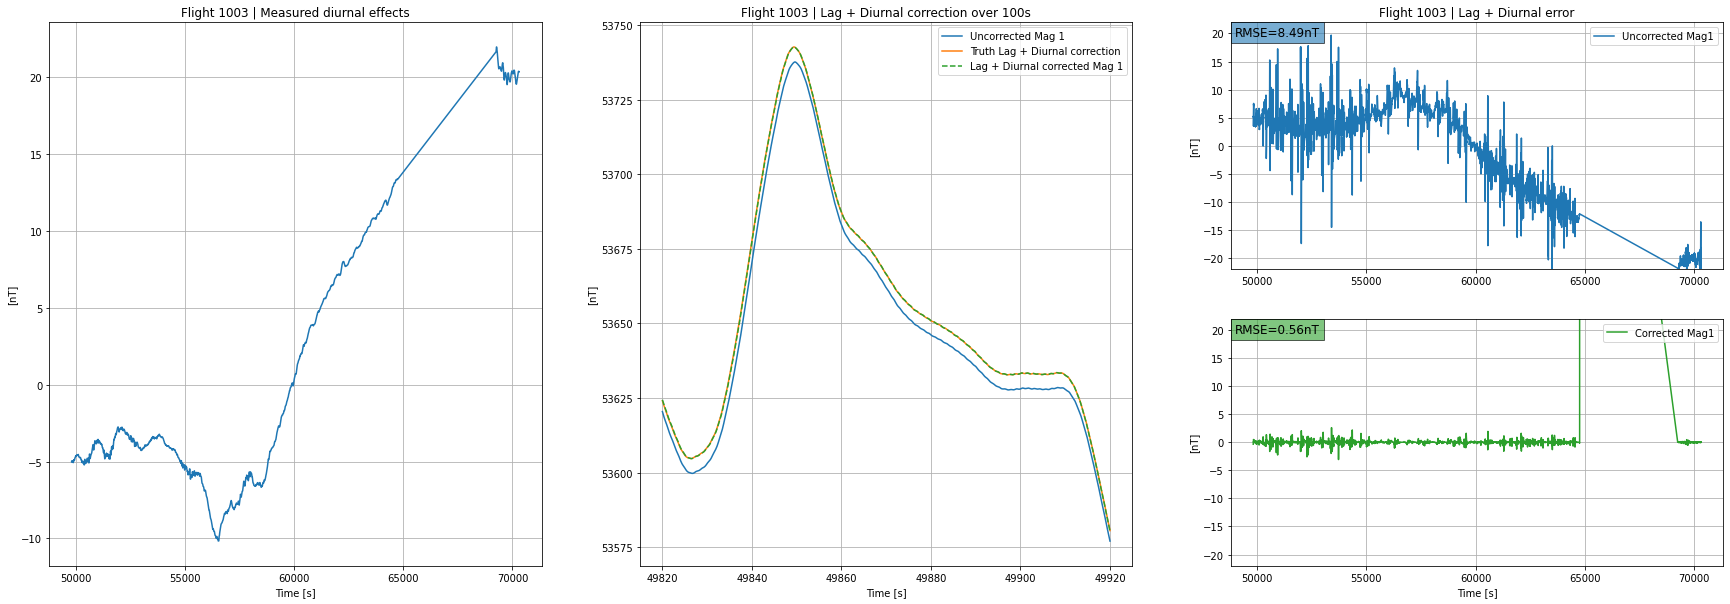

In [36]:
plt.figure(figsize=[30,10])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,6)

# Diurnal plot
ax1.plot(df_sel_flight['DIURNAL'])
ax1.set_title(f'Flight 100{w_flight.value} | Measured diurnal effects')
ax1.set_ylabel('[nT]')
ax1.set_xlabel('Time [s]')
ax1.grid()

# Diurnal correction
our_dc_cor = our_lag_cor-UNLAG_df['DIURNAL']

ax2.plot(UNLAG_df[['COMPMAG1','DCMAG1']].loc[:df_sel_flight.index[0]+100])
ax2.plot(our_dc_cor.loc[:df_sel_flight.index[0]+100],'--')
ax2.legend(['Uncorrected Mag 1','Truth Lag + Diurnal correction','Lag + Diurnal corrected Mag 1'])
ax2.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal correction over 100s')
ax2.set_ylabel('[nT]')
ax2.set_xlabel('Time [s]')
ax2.grid()

# Diurnal errors
uncor_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['DCMAG1'])

ax3.plot(UNLAG_df['DCMAG1']-UNLAG_df['COMPMAG1'],'C0')
ax3.grid()
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal error')
ax3.axes.set_ylim(-22,22)
ax3.legend(['Uncorrected Mag1'],loc='upper right')
ax3.text(df_sel_flight.index[0]-830,19.5,f'RMSE={uncor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))


cor_rmse = magnav.rmse(our_dc_cor,UNLAG_df['DCMAG1'])

ax4.plot(df_sel_flight['DCMAG1']-our_dc_cor,'C2')
ax4.grid()
ax4.set_ylabel('[nT]')
ax4.set_xlabel('Time [s]')
ax4.axes.set_ylim(-22,22)
ax4.legend(['Corrected Mag1'],loc='upper right')
ax4.text(df_sel_flight.index[0]-830,19.5,f'RMSE={cor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))

plt.show()

<font size='4'>Explication :</font><br>
The error come from lag correction, we have the exact same diurnal corection as the truth.

## 5.4 - IGRF correction

In [37]:
# definition IGRF

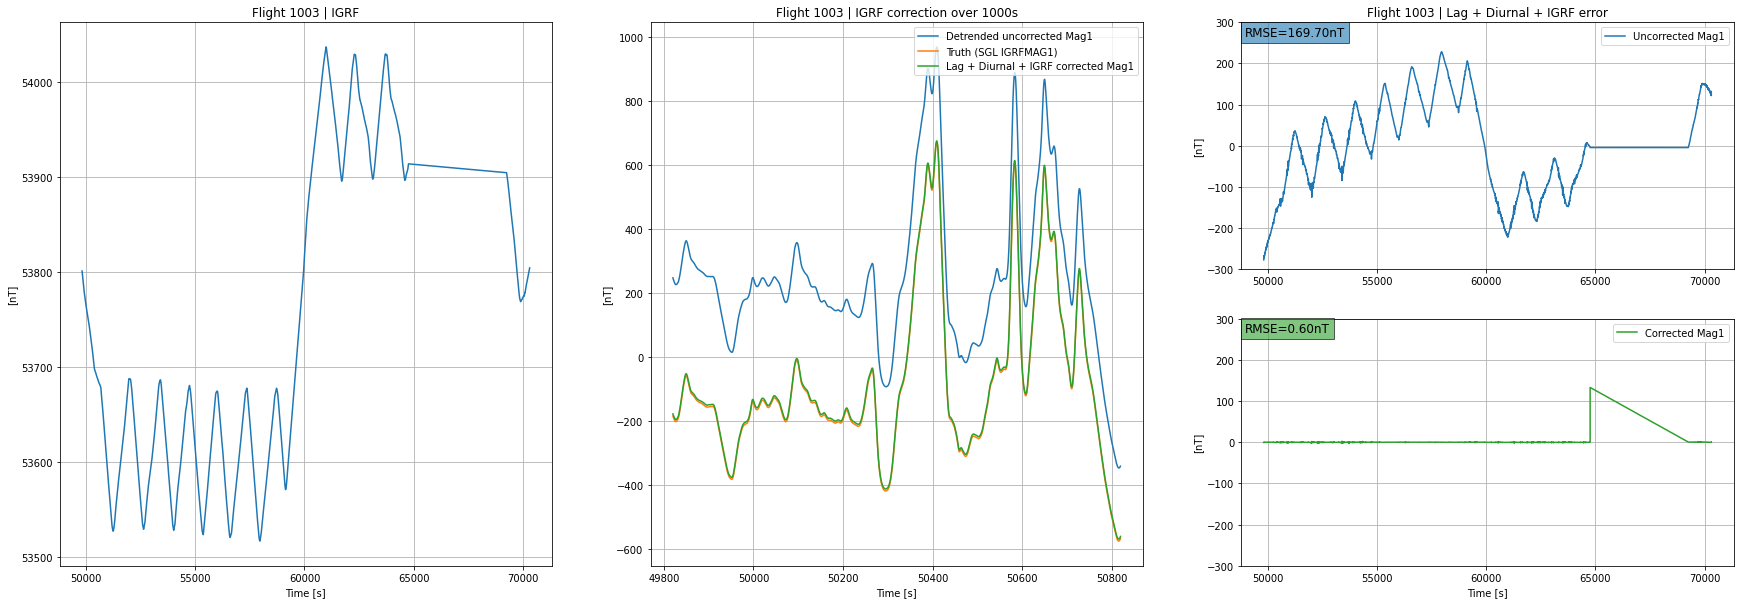

In [57]:
lat = UNLAG_df['LAT']
lon = UNLAG_df['LONG']
h = UNLAG_df['BARO']*1e-3# kilometers above WGS84 ellipsoid, no impact on rmse due to low altitude
date = datetime.datetime(2020, 7, 20)

Be, Bn, Bu = ppigrf.igrf(lon,lat,h,date)

our_IGRF_cor = our_dc_cor - np.sqrt(Be**2+Bn**2+Bu**2)[0]

plt.figure(figsize=[30,10])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,6)

# IGRF offset
ax1.plot(UNLAG_df.index,np.sqrt(Be**2+Bn**2+Bu**2)[0])
ax1.set_title(f'Flight 100{w_flight.value} | IGRF')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.grid()

# IGRF correction
ax2.plot(UNLAG_df.index[:10000],signal.detrend(UNLAG_df['COMPMAG1'])[:10000])
ax2.plot(UNLAG_df['IGRFMAG1'][:UNLAG_df.index[0]+1000])
ax2.plot(our_IGRF_cor[:UNLAG_df.index[0]+1000])
ax2.legend(['Detrended uncorrected Mag1','Truth (SGL IGRFMAG1)','Lag + Diurnal + IGRF corrected Mag1'],loc='upper right')
ax2.set_title(f'Flight 100{w_flight.value} | IGRF correction over 1000s')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.grid()

# IGRF error
uncor_rmse = magnav.rmse(UNLAG_df['COMPMAG1'],UNLAG_df['IGRFMAG1'])
cor_rmse = magnav.rmse(our_IGRF_cor,UNLAG_df['IGRFMAG1'])

ax3.plot(UNLAG_df.index,signal.detrend(UNLAG_df['IGRFMAG1']-UNLAG_df['COMPMAG1']),'C0')
ax3.grid()
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Lag + Diurnal + IGRF error')
ax3.axes.set_ylim(-300,300)
ax3.legend(['Uncorrected Mag1'],loc='upper right')
ax3.text(UNLAG_df.index[0]-850,267,f'RMSE={uncor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6))

ax4.plot(UNLAG_df.index,signal.detrend(UNLAG_df['IGRFMAG1']-our_IGRF_cor),'C2')
ax4.grid()
ax4.set_ylabel('[nT]')
ax4.set_xlabel('Time [s]')
ax4.axes.set_ylim(-300,300)
ax4.legend(['Corrected Mag1'],loc='upper right')
ax4.text(UNLAG_df.index[0]-850,267,f'RMSE={cor_rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C2',alpha=0.6))


plt.show()

## 5.5 - Tolles Lawson vs Tolles Lawson + corrections

In [96]:
def apply_corrections(df,Lag=True,Diurnal=True,IGRF=True):
    
    mag_measurements = ['TL_comp_mag5_cl','TL_comp_mag4_cl','TL_comp_mag3_cl','TL_comp_mag2_cl','TL_comp_mag1_cl',
                        'TL_comp_mag5_sq','TL_comp_mag4_sq','TL_comp_mag3_sq','TL_comp_mag2_sq','TL_comp_mag1_sq',
                        'TL_comp_mag5_sqcl','TL_comp_mag4_sqcl','TL_comp_mag3_sqcl','TL_comp_mag2_sqcl','TL_comp_mag1_sqcl',
                        'COMPMAG1']
    # Lag cor
    if Lag == True:
        unlag = df[mag_measurements].drop([df.index[0],df.index[1]])
        unlag.index = df.index[:-2]
        UNLAG_df = df.drop([df.index[-1],df.index[-2]])
        UNLAG_df = UNLAG_df.drop(columns=mag_measurements)
        UNLAG_df[mag_measurements] = unlag
    
    # Diurnal cor
    
    
    # IGRF cor
    

    
    return UNLAG_df
    

['MSL_Z', 'NORM_ACC', 'BARO', 'CUR_ACHi', 'CUR_ACLo', 'CUR_ACPWR', 'CUR_BAT1', 'CUR_BAT2', 'CUR_COM1', 'CUR_FLAP', 'CUR_IHTR', 'CUR_OUTPWR', 'CUR_SRVO_I', 'CUR_SRVO_M', 'CUR_SRVO_O', 'CUR_STRB', 'CUR_TANK', 'DEM', 'DIURNAL', 'DRAPE', 'FLT', 'FLUXB_TOT', 'FLUXB_X', 'FLUXB_Y', 'FLUXB_Z', 'FLUXC_TOT', 'FLUXC_X', 'FLUXC_Y', 'FLUXC_Z', 'FLUXD_TOT', 'FLUXD_X', 'FLUXD_Y', 'FLUXD_Z', 'INS_ACC_X', 'INS_ACC_Y', 'INS_ACC_Z', 'INS_HGT', 'AZIMUTH', 'INS_LAT', 'INS_LON', 'PITCH', 'ROLL', 'INS_VEL_N', 'INS_VEL_V', 'INS_VEL_W', 'INS_WANDER', 'LAT', 'LAT_ACC', 'LONG', 'LONG_ACC', 'DCMAG1', 'IGRFMAG1', 'LAGMAG1', 'UNCOMPMAG1', 'UNCOMPMAG2', 'UNCOMPMAG3', 'UNCOMPMAG4', 'UNCOMPMAG5', 'OGS_HGT', 'OGS_MAG', 'PITCHRT', 'PITOT_P', 'RADAR', 'ROLLRT', 'STATIC_P', 'LINE', 'TOPO', 'TOT_P', 'TRUE_AS', 'TIME', 'UTM_X', 'UTM_Y', 'UTM_Z', 'V_ACCn', 'V_ACCp', 'V_ACPWR', 'V_BACK', 'V_BACKn', 'V_BACKp', 'V_BAT1', 'V_BAT2', 'V_BLOCK', 'V_CABT', 'V_FAN', 'V_GYRO1', 'V_GYRO2', 'V_OUTPWR', 'V_RESn', 'V_RESp', 'V_SERVO', 'YA

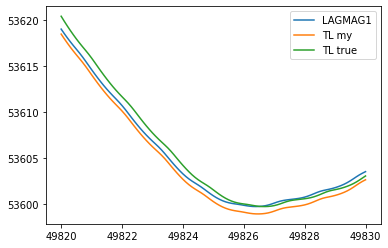

In [97]:
COR_df = apply_corrections(df_sel_flight)
plt.plot(df_sel_flight['LAGMAG1'][:df_sel_flight.index[0]+10],label='LAGMAG1')
plt.plot(COR_df['TL_comp_mag1_sq'][:df_sel_flight.index[0]+10],label='TL my')
plt.plot(df_sel_flight['COMPMAG1'][:df_sel_flight.index[0]+10],label='TL true')
plt.legend()

In [88]:
mag_measurements = ['TL_comp_mag5_cl','TL_comp_mag4_cl','TL_comp_mag3_cl','TL_comp_mag2_cl','TL_comp_mag1_cl',
                        'TL_comp_mag5_sq','TL_comp_mag4_sq','TL_comp_mag3_sq','TL_comp_mag2_sq','TL_comp_mag1_sq',
                        'TL_comp_mag5_sqcl','TL_comp_mag4_sqcl','TL_comp_mag3_sqcl','TL_comp_mag2_sqcl','TL_comp_mag1_sqcl',
                        'COMPMAG1']
UNLAG_df = df_sel_flight.drop(index=[df_sel_flight.index[-1],df_sel_flight.index[-2]],columns=mag_measurements)

list(UNLAG_df.columns)

['MSL_Z',
 'NORM_ACC',
 'BARO',
 'CUR_ACHi',
 'CUR_ACLo',
 'CUR_ACPWR',
 'CUR_BAT1',
 'CUR_BAT2',
 'CUR_COM1',
 'CUR_FLAP',
 'CUR_IHTR',
 'CUR_OUTPWR',
 'CUR_SRVO_I',
 'CUR_SRVO_M',
 'CUR_SRVO_O',
 'CUR_STRB',
 'CUR_TANK',
 'DEM',
 'DIURNAL',
 'DRAPE',
 'FLT',
 'FLUXB_TOT',
 'FLUXB_X',
 'FLUXB_Y',
 'FLUXB_Z',
 'FLUXC_TOT',
 'FLUXC_X',
 'FLUXC_Y',
 'FLUXC_Z',
 'FLUXD_TOT',
 'FLUXD_X',
 'FLUXD_Y',
 'FLUXD_Z',
 'INS_ACC_X',
 'INS_ACC_Y',
 'INS_ACC_Z',
 'INS_HGT',
 'AZIMUTH',
 'INS_LAT',
 'INS_LON',
 'PITCH',
 'ROLL',
 'INS_VEL_N',
 'INS_VEL_V',
 'INS_VEL_W',
 'INS_WANDER',
 'LAT',
 'LAT_ACC',
 'LONG',
 'LONG_ACC',
 'DCMAG1',
 'IGRFMAG1',
 'LAGMAG1',
 'UNCOMPMAG1',
 'UNCOMPMAG2',
 'UNCOMPMAG3',
 'UNCOMPMAG4',
 'UNCOMPMAG5',
 'OGS_HGT',
 'OGS_MAG',
 'PITCHRT',
 'PITOT_P',
 'RADAR',
 'ROLLRT',
 'STATIC_P',
 'LINE',
 'TOPO',
 'TOT_P',
 'TRUE_AS',
 'TIME',
 'UTM_X',
 'UTM_Y',
 'UTM_Z',
 'V_ACCn',
 'V_ACCp',
 'V_ACPWR',
 'V_BACK',
 'V_BACKn',
 'V_BACKp',
 'V_BAT1',
 'V_BAT2',
 'V_BLOCK',
 'V_CA

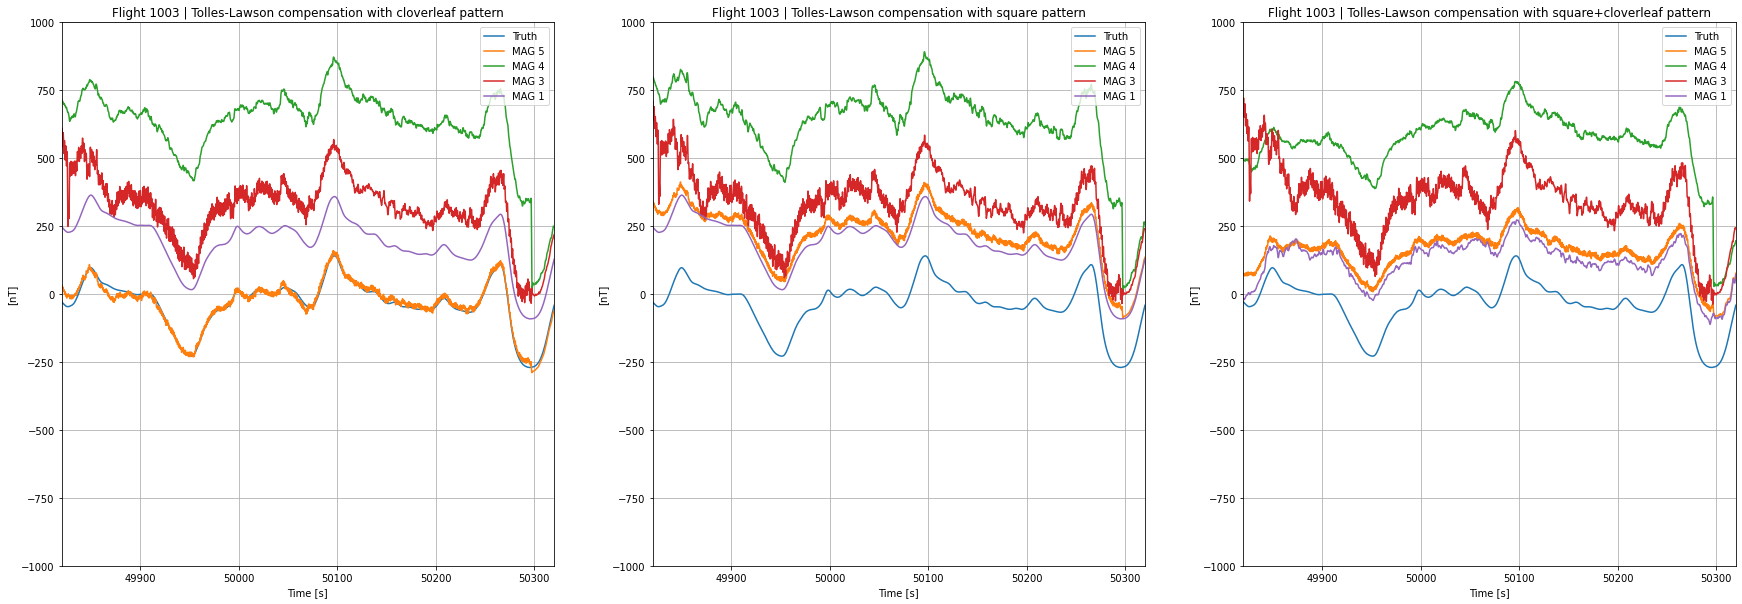

In [59]:
COR_df = df_sel_flight.drop([df_sel_flight.index[-1],df_sel_flight.index[-2]])
cormag = df_sel_flight['TL_comp_mag5_cl'].drop([df_sel_flight.index[0],df_sel_flight.index[1]]) # a faire pour tout les autres ainsi que cor diur et IGRF
cormag.index = COR_df.index
cormag = cormag-COR_df['DIURNAL']
cormag = cormag-np.sqrt(Be**2+Bn**2+Bu**2)[0]



fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,10])

# Cloverleaf pattern
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['IGRFMAG1']),label='Truth')
ax1.plot(cormag,label='MAG 5')
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag4_cl']),label='MAG 4')
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag3_cl']),label='MAG 3')
ax1.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag1_cl']),label='MAG 1')
# ax1.plot(df_sel_flight['TL_comp_mag2_cl']-np.mean(df_sel_flight['TL_comp_mag2_cl']),label='MAG 2')

ax1.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax1.axes.set_ylim(-1000,1000)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with cloverleaf pattern')
ax1.legend(loc='upper right')
ax1.grid()

# Square pattern
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['IGRFMAG1']),label='Truth')
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag5_sq']),label='MAG 5')
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag4_sq']),label='MAG 4')
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag3_sq']),label='MAG 3')
ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag1_sq']),label='MAG 1')
#ax2.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag2_sq']),label='MAG 2')

ax2.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax2.axes.set_ylim(-1000,1000)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square pattern')
ax2.legend(loc='upper right')
ax2.grid()

# Square+Cloverleaf pattern
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['IGRFMAG1']),label='Truth')
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag5_sqcl']),label='MAG 5')
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag4_sqcl']),label='MAG 4')
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag3_sqcl']),label='MAG 3')
ax3.plot(df_sel_flight.index,signal.detrend(df_sel_flight['TL_comp_mag1_sqcl']),label='MAG 1')
# ax3.plot(df_sel_flight['TL_comp_mag2_sqcl']-np.mean(df_sel_flight['TL_comp_mag2_sqcl']),label='MAG 2')

ax3.axes.set_xlim(df_sel_flight.index[0],df_sel_flight.index[0]+500)
ax3.axes.set_ylim(-1000,1000)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('[nT]')
ax3.set_title(f'Flight 100{w_flight.value} | Tolles-Lawson compensation with square+cloverleaf pattern')
ax3.legend(loc='upper right')
ax3.grid()

# 5 - Feature selection

Histograms plots

In [ ]:
df_chall.hist(bins=50,figsize=[25,20])
plt.show()

## 5.1 - Main feature selection

### 5.1.1 - Correlation

In [ ]:
corr_sglcomp = df_chall.drop(columns=['LINE']).corr()[['IGRFMAG1']].abs().sort_values(by='IGRFMAG1',ascending=False)
corr_sglcomp_spearman = df_chall.drop(columns=['LINE']).corr(method='spearman')[['IGRFMAG1']].abs().sort_values(by='IGRFMAG1',ascending=False)

corr_sglcomp = corr_sglcomp.drop('IGRFMAG1')
corr_sglcomp_spearman = corr_sglcomp_spearman.drop('IGRFMAG1')



In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[3,18])

df_corr_htmap = sns.heatmap(corr_sglcomp,annot=True,fmt=".3f",ax=ax1,cbar=False)
df_corr_htmap_spear = sns.heatmap(corr_sglcomp_spearman,annot=True,fmt=".3f",ax=ax2,cbar=False)

df_corr_htmap_spear.set_title('Spearman')
df_corr_htmap.set_title('Pearson')
df_corr_htmap_spear.yaxis.tick_right()
df_corr_htmap_spear.set_yticklabels(df_corr_htmap_spear.get_yticklabels(),rotation=0)
plt.show()

### 5.1.2 - Mutual informations

In [ ]:
non_float = np.sum(df_chall.dtypes == int)
print(f"Number of non float value : {non_float} (if different from 0, make_mi_scores don't work)")

In [ ]:
def make_mi_scores(X,y,n_neighbors=3):
    
    mi_scores = mutual_info_regression(X,y,n_neighbors=n_neighbors)
    mi_scores = pd.Series(mi_scores, name = 'Mutual Informations scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

def plot_mi_scores(scores):
    
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.grid()
    plt.title("Mutual Information Scores")

In [ ]:
mi_scores = make_mi_scores(df_chall.drop(columns=['IGRFMAG1']),df_chall['IGRFMAG1'],n_neighbors=5)

In [ ]:
fig, ax = plt.subplots(figsize=[5,20])
plot_mi_scores(mi_scores)

### 5.1.3 - PCA

In [ ]:
def plot_variance(pca,width=8):
    fig, axs = plt.subplots(1,2)
    n = pca.n_components_
    grid = np.arange(1,n+1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel='Component',title='% Explained Variance', ylim=(0.0,1.0))
    
    # Cumulative variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0,grid],np.r_[0,cv],"o-")
    axs[1].set(xlabel='Component',title='% Cumulative Variance', ylim=(0.0,1.0))
    
    fig.set(figwidth=width)

In [ ]:
df_chall_scaled = (df_chall.drop(columns=['LINE','IGRFMAG1'])-df_chall.drop(columns=['LINE','IGRFMAG1']).mean(axis=0))/df_chall.drop(columns=['LINE','IGRFMAG1']).std(axis=0)

var = 0.90
pca = PCA(n_components = var)
pca.fit(df_chall_scaled)

components = len(pca.explained_variance_ratio_*100)
print(f'Number of components needed to explain {var*100}% of variance: {components}\n')

plot_variance(pca,width=15)

In [ ]:
print('=============================================================================================')
print('|                     Top 5 most important features in each component                       |')
print('=============================================================================================')

pca_components = abs(pca.components_)
for row in range(pca_components.shape[0]):
    temp = np.argpartition(-(pca_components[row]),5)
    indices = temp[np.argsort((-pca_components[row])[temp])][:5]
    print(f'Component {row}: {df_chall_scaled.columns[indices].to_list()}')

In [ ]:
df_chall_PCA = pca.transform(df_chall_scaled)

## 5.2 - Searching for other useful data

Creation residue between true and mags

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))

df_corr = pd.DataFrame()

# Residue between uncomp mags and true - no rescale 
df_corr['res_MAG5'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['UNCOMPMAG5'])
df_corr['res_MAG4'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['UNCOMPMAG4'])
df_corr['res_MAG3'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['UNCOMPMAG3'])
df_corr['res_MAG2'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['UNCOMPMAG2'])

# Residue between uncomp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG5'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG4'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG3'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG2'].tolist(),(-1,1)))

# Residue between TL square pattern comp mags and true - no rescale
df_corr['res_MAG5_tlsq'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag5_sq'])
df_corr['res_MAG4_tlsq'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag4_sq'])
df_corr['res_MAG3_tlsq'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag3_sq'])
df_corr['res_MAG2_tlsq'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag2_sq'])

# Residue between TL square pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlsq'].tolist(),(-1,1)))

# Residue between TL cloverleaf pattern comp mags and true - no rescale
df_corr['res_MAG5_tlcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag5_cl'])
df_corr['res_MAG4_tlcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag4_cl'])
df_corr['res_MAG3_tlcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag3_cl'])
df_corr['res_MAG2_tlcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag2_cl'])

# Residue between TL cloverleaf pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlcl'].tolist(),(-1,1)))

# Residue between TL square+cloverleaf pattern comp mags and true - no rescale
df_corr['res_MAG5_tlsqcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag5_sqcl'])
df_corr['res_MAG4_tlsqcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag4_sqcl'])
df_corr['res_MAG3_tlsqcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag3_sqcl'])
df_corr['res_MAG2_tlsqcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag2_sqcl'])


# Residue between TL square+cloverleaf pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlsqcl'].tolist(),(-1,1)))

In [ ]:
variables = ['CUR_ACHi', 'CUR_ACLo', 'CUR_ACPWR', 'CUR_BAT1', 'CUR_BAT2', 'CUR_COM1',
       'CUR_FLAP', 'CUR_IHTR', 'CUR_OUTPWR', 'CUR_SRVO_I', 'CUR_SRVO_M',
       'CUR_SRVO_O', 'CUR_STRB', 'CUR_TANK', 'DIURNAL', 'FLUXB_TOT', 'FLUXB_X',
       'FLUXB_Y', 'FLUXB_Z', 'FLUXC_TOT', 'FLUXC_X', 'FLUXC_Y', 'FLUXC_Z',
       'FLUXD_TOT', 'FLUXD_X', 'FLUXD_Y', 'FLUXD_Z', 'INS_ACC_X', 'INS_ACC_Y',
       'INS_ACC_Z', 'AZIMUTH', 'PITCH', 'ROLL','V_ACCn', 'V_ACCp',
       'V_ACPWR', 'V_BACK', 'V_BACKn', 'V_BACKp', 'V_BAT1', 'V_BAT2',
       'V_BLOCK', 'V_CABT', 'V_FAN', 'V_GYRO1', 'V_GYRO2', 'V_OUTPWR',
       'V_RESn', 'V_RESp', 'V_SERVO', 'FLUXB_X_grad', 'FLUXB_Y_grad',
       'FLUXB_Z_grad', 'FLUXC_X_grad', 'FLUXC_Y_grad', 'FLUXC_Z_grad',
       'FLUXD_X_grad', 'FLUXD_Y_grad', 'FLUXD_Z_grad', 'PITCH_grad',
       'ROLL_grad', 'AZIMUTH_grad']
residues_list = ['res_MAG5','res_MAG4','res_MAG3','res_MAG2','res_MAG5_rsc',
                 'res_MAG4_rsc','res_MAG3_rsc','res_MAG2_rsc','res_MAG5_tlsq',
                 'res_MAG4_tlsq','res_MAG3_tlsq', 'res_MAG2_tlsq', 'res_MAG5_rsc_tlsq',
                 'res_MAG4_rsc_tlsq','res_MAG3_rsc_tlsq','res_MAG2_rsc_tlsq',
                 'res_MAG5_tlcl','res_MAG4_tlcl','res_MAG3_tlcl','res_MAG2_tlcl',
                 'res_MAG5_rsc_tlcl','res_MAG4_rsc_tlcl','res_MAG3_rsc_tlcl',
                 'res_MAG2_rsc_tlcl','res_MAG5_tlsqcl','res_MAG4_tlsqcl',
                 'res_MAG3_tlsqcl','res_MAG2_tlsqcl','res_MAG5_rsc_tlsqcl',
                 'res_MAG4_rsc_tlsqcl','res_MAG3_rsc_tlsqcl','res_MAG2_rsc_tlsqcl']
df_corr[variables] = df_chall[variables]
corr_residues = df_corr.corr()
corr_residues = corr_residues.drop(columns=variables)
corr_residues = corr_residues.drop(residues_list)

In [ ]:
fig, ax = plt.subplots(figsize=[25,20])

df_corr_htmap = sns.heatmap(corr_residues,annot=True,fmt=".3f",ax=ax,cmap="Spectral",cbar_kws={"shrink":.5})
plt.show()

## 5.3 - Pre-Selected features

In [ ]:
features = ['TL_comp_mag5_sq','DIURNAL','UNCOMPMAG5','AZIMUTH','UNCOMPMAG4','UNCOMPMAG2','FLUXB_TOT','FLUXC_Y','UNCOMPMAG3'] # Mi score > 1 ou corr > 0.4
features = features + ['V_BAT2','V_SERVO','V_BAT1','V_ACCp','ROLL'] # Correlation with residue > 0.45

# 6 - Dataset

## 6.1 - Challenge solution Dataset

In [ ]:
for n in tqdm(range(2,6)):
    
    df = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt100{n}')
    
    calcIGRF = df['DCMAG1']-df['IGRFMAG1'] 
    
    A = magnav.create_TL_A(df['FLUXB_X'],df['FLUXB_Y'],df['FLUXB_Z'])
    
    df['TL_comp_mag3_sq'] = np.reshape(df['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
    df['TL_comp_mag4_sq'] = np.reshape(df['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
    df['TL_comp_mag5_sq'] = np.reshape(df['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))
    
    df['TL_comp_mag3_sq'] = df['TL_comp_mag3_sq']-df['DIURNAL']-calcIGRF
    df['TL_comp_mag4_sq'] = df['TL_comp_mag4_sq']-df['DIURNAL']-calcIGRF
    df['TL_comp_mag5_sq'] = df['TL_comp_mag5_sq']-df['DIURNAL']-calcIGRF
    
    df_sol = df[['FLUXB_TOT','FLUXB_X','FLUXC_TOT','FLUXC_Y','FLUXD_Y','FLUXD_Z','TL_comp_mag3_sq',
                 'UNCOMPMAG3','TL_comp_mag4_sq','TL_comp_mag5_sq','V_CABT','LINE','IGRFMAG1']]
    
    # export to HDF5
    df_sol.to_hdf(f'../data/interim/Sol_dataset.h5',key=f'Flt100{n}')
    # export to csv
    df_sol.to_csv(f'../data/interim/Sol_dataset_csv/Flt100{n}.csv')

In [ ]:
df_sol = df_chall[['FLUXB_TOT','FLUXB_X','FLUXC_TOT','FLUXC_Y','FLUXD_Y','FLUXD_Z','TL_comp_mag3_sq','UNCOMPMAG3','TL_comp_mag4_sq','TL_comp_mag5_sq','V_CABT','LINE']]
df_sol.head()

# export to HDF5
df_sol.to_hdf('../data/interim/Sol_dataset.h5',key='Flt1003')
# export to csv
df_sol.to_csv(f'../data/interim/Sol_dataset_csv/Flt1003.csv')